cpu


In [41]:
import sys
sys.path.append('/data/home/meiri.yoav/biomed_proj/pyPPG')

from Prefiltering import*
from FiducialPoints import*
from Biomarkers2 import*
from Summary import*
from Statistics import*
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns


annot_files = sorted(glob.glob("/data/home/meiri.yoav/biomed_proj/data/annotated/*"))
af_files = [f for f in annot_files if 'non' not in f]
non_af_files = [f for f in annot_files if 'non' in f]

subs_features = {}

for f in annot_files:
    sub_name = tuple(f.split('/')[-1].split('.')[0].split('_')[1:])
    with open(f, 'rb') as f:
        annot = pkl.load(f)
    subs_features[sub_name] = annot['osignal_data']

In [42]:
# convert the dict to dataset of multiple lables
features = None
labels = [] 
for sub_name, sub_features in subs_features.items():
    if features is None:
        features = sub_features.to_numpy()
    else:
        features = np.vstack((features, sub_features.to_numpy()))
    labels.extend([sub_name]*len(sub_features))
    
# convert each tuple in labels to sum of strings with _ as seperator
labels = ['_'.join(l) for l in labels]
labels_no_numbers = ['_'.join(l.split('_')[::-1][1:]) for l in labels]

pca = PCA(n_components=2)
scaler = StandardScaler()

pipe = Pipeline([('scaler', scaler), ('pca', pca)])
pipe.fit(features)
features_pca = pipe.transform(features)
features_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(features)

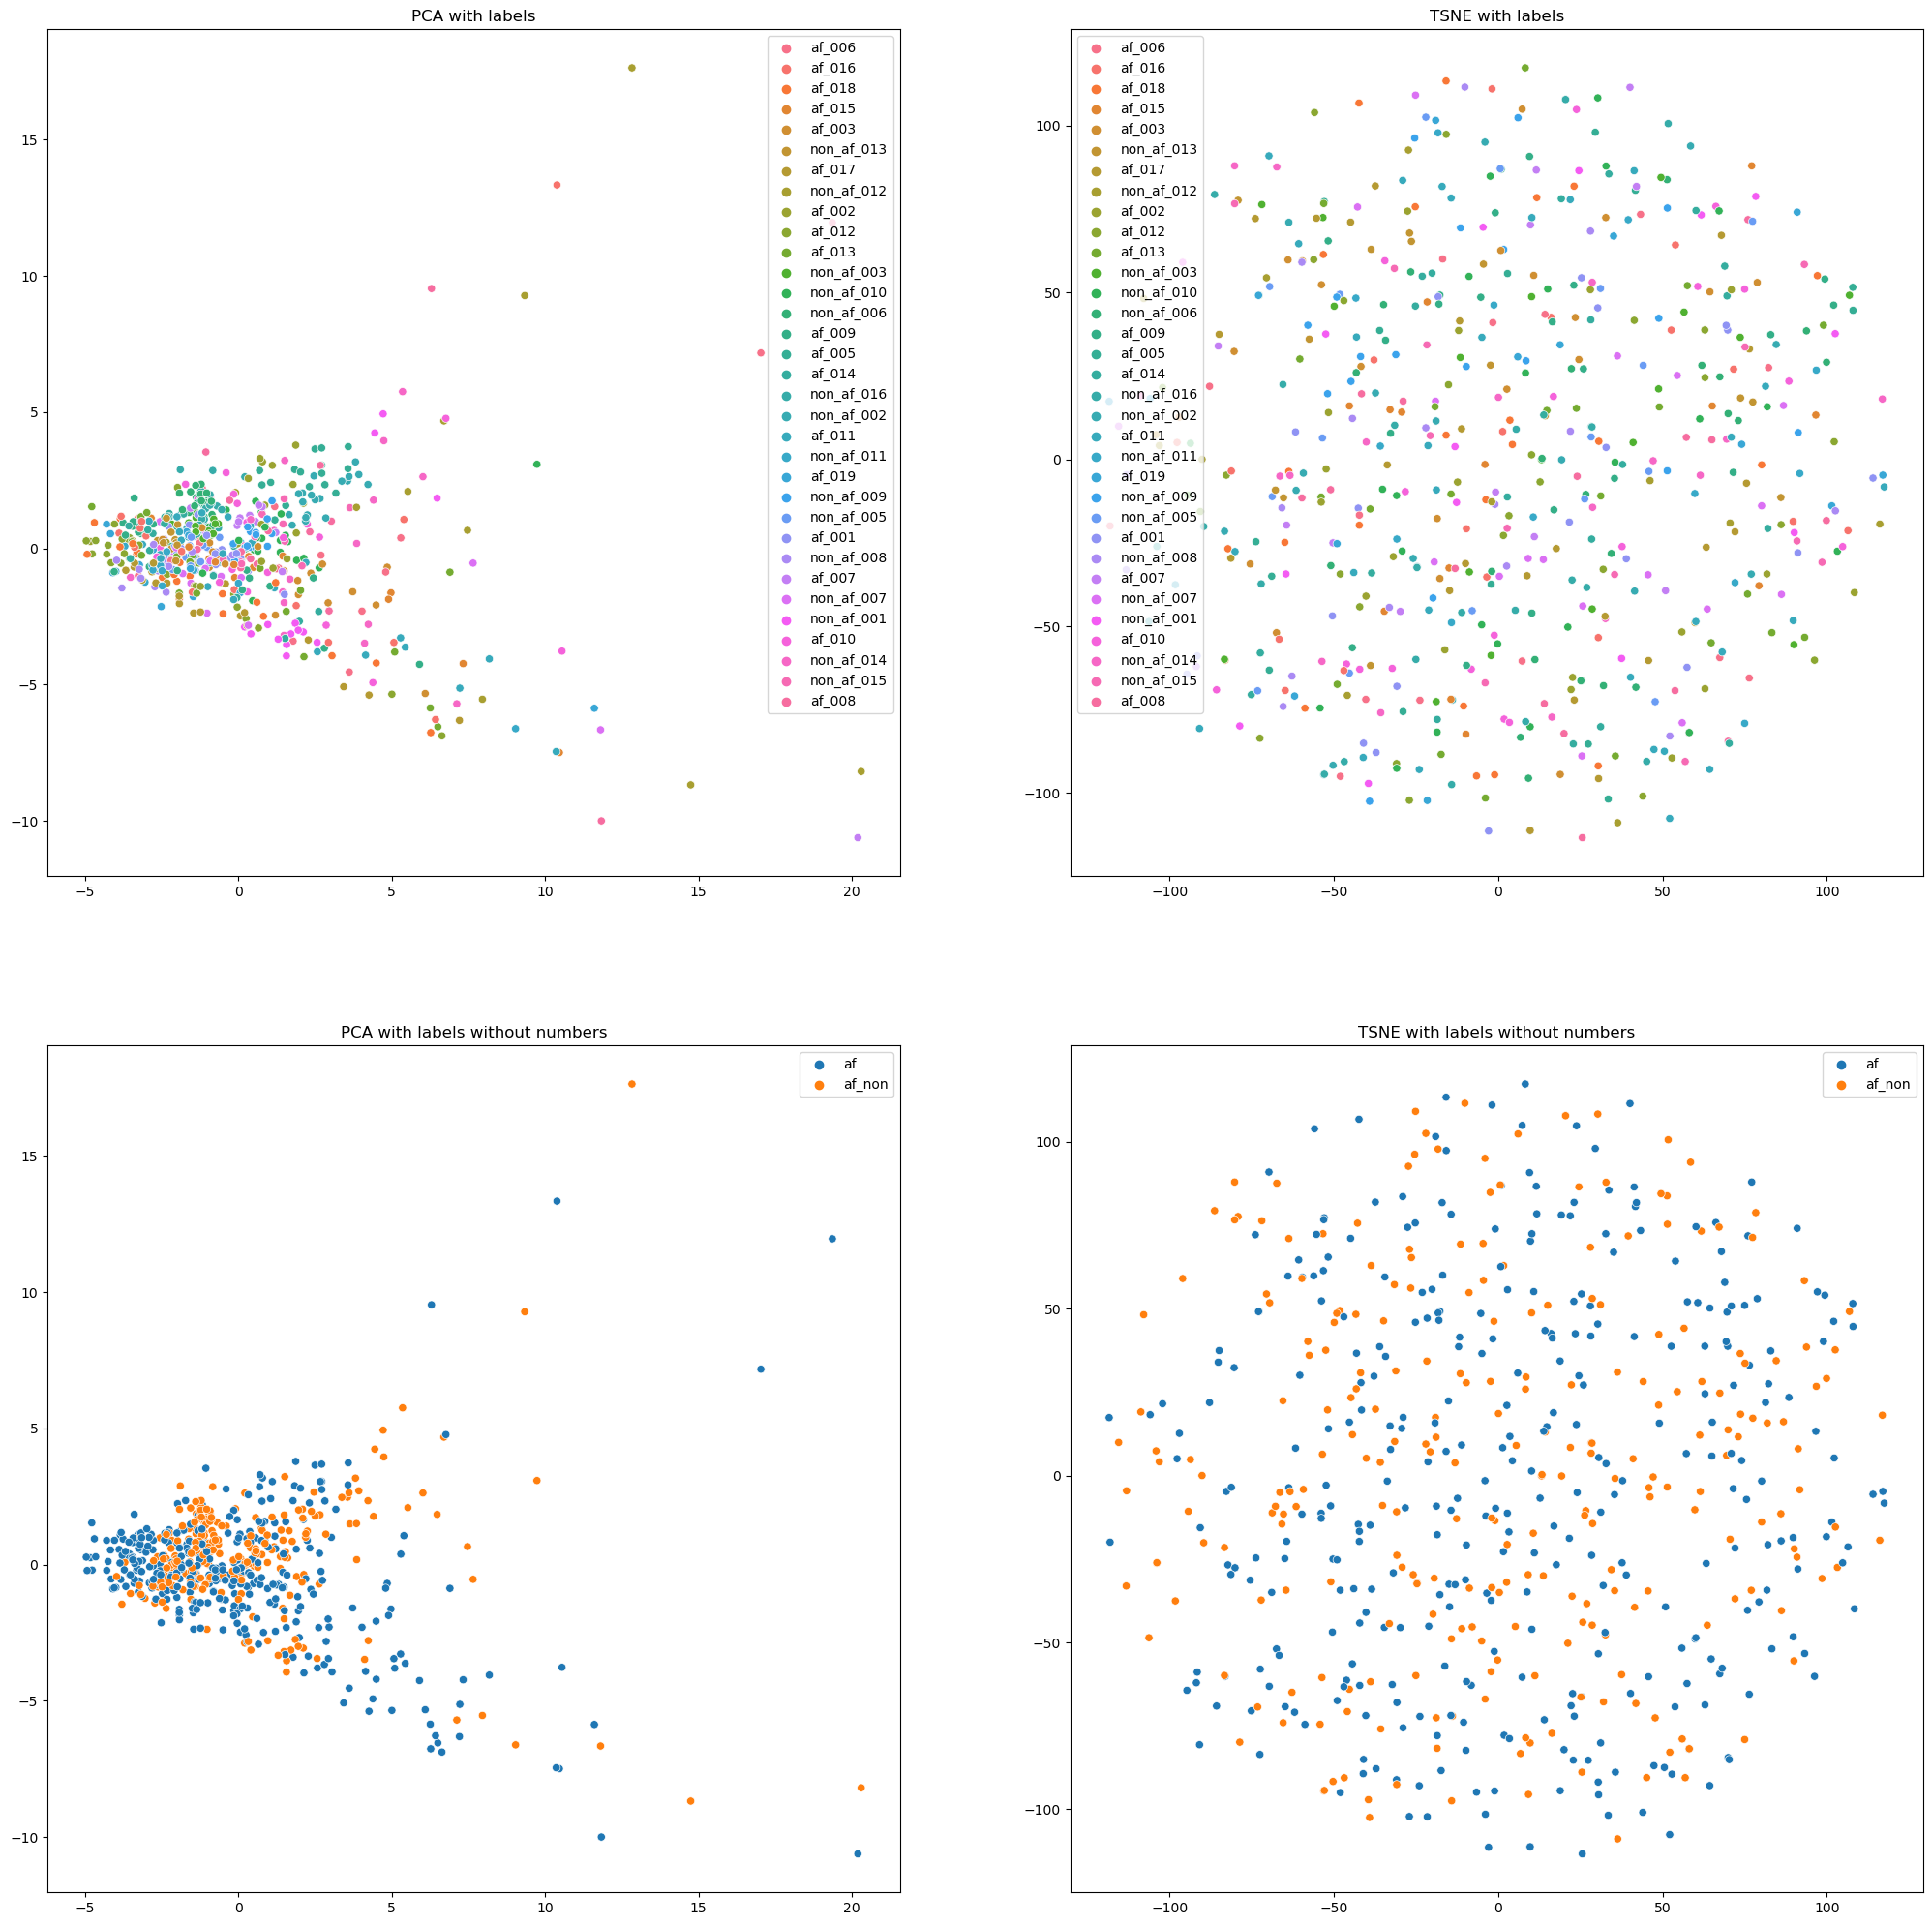

In [47]:
idx = np.random.choice(len(features_pca), 600, replace=False)
features_pca = features_pca[idx]
features_tsne = features_tsne[idx]
labels = np.array(labels)[idx]
labels_no_numbers = np.array(labels_no_numbers)[idx]

fig, axs = plt.subplots(2, 2, figsize=(25,25))
# plot using seaborn
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1], hue=labels, ax=axs[0,0])
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1], hue=labels, ax=axs[0,1])
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1], hue=labels_no_numbers, ax=axs[1,0])
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1], hue=labels_no_numbers, ax=axs[1,1])

axs[0,0].set_title('PCA with labels')
axs[0,1].set_title('TSNE with labels')
axs[1,0].set_title('PCA with labels without numbers')
axs[1,1].set_title('TSNE with labels without numbers')

plt.show()